In [39]:
# Global imports
import sys, os
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from collections import Counter, OrderedDict

%matplotlib inline 
#%matplotlib widget

import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
#plt.style.use(['dark_background'])

import numpy as np
import json
import collections
from scipy import stats
import random
import math
from datetime import datetime

# Local import
sys.path.insert(0, '../training/methods/')
# Import the neural network architectures:
from MLP import Net as MLP
from CNN import Net as CNN

sys.path.insert(0, '../training/src/')
from dataset import merger_dataset, splitDataLoader, ToTensor, Normalize

In [40]:
pwd

'/home/mvvasist/EagleMergers/DeepLearning/evaluation'

# User-defined parameters

In [41]:
working_dir = "/home/mvvasist/EagleMergers/"
path_to_models = working_dir+'models/'
path_to_datasets = working_dir+"data/"

dl_arch='mlp'  #'cnn'
nb_layer = 2
train_val_dataset_size = 1280
output_dim = 2
optimizer_name =  'SGD' #"Adam" 
batch_size = 32 
learning_rate = '1e-4' 
nb_epoch = 50
metric = 'rmse'
split_train = '90'

test_dataset_size = 105

# Display the training and validation losses

## Read the train/val losses

In [42]:
if dl_arch == 'mlp':
    layer_str = '_2hl_'
elif dl_arch == 'cnn':
    layer_str = '_3cv_'
else:
    raise ValueError("the model name specified is not valid")

model_name = 'model_'+str(train_val_dataset_size)+'cubes_'+str(output_dim)+'targ_'+dl_arch+layer_str+'bs'+str(batch_size)+\
'_lr'+str(learning_rate)+'_'+str(nb_epoch)+'ep_opt'+str(optimizer_name)+'_split'+split_train+'_'+metric+'_relu1_final_w300'

print(model_name)
#model_1280cubes_2targ_mlp_2hl_bs32_lr1e-4_50ep_optSGD_split90_rmse_relu1_final_w300


metrics_file = path_to_models+model_name+'/metrics.json'

with open(metrics_file) as json_file:
    data = json.load(json_file)

model_1280cubes_2targ_mlp_2hl_bs32_lr1e-4_50ep_optSGD_split90_rmse_relu1_final_w300


## Plot the losses

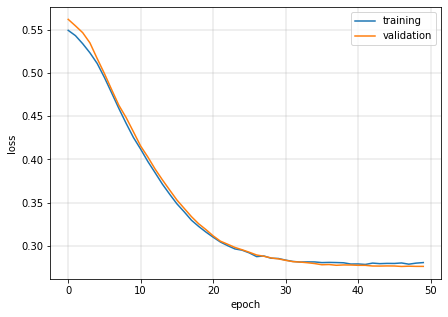

In [43]:
fig = plt.figure(1, figsize=(7,5))
plt.plot(data['train_loss'], label='training')
plt.plot(data['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")
plt.grid(linewidth=0.4)

#fig.savefig("train_val_loss_"+model_name+".png")

In [44]:
print(np.min(data['train_loss']))
print(np.min(data['val_loss']))

0.27835011458955705
0.2760324410096867


# Load the model

In [45]:
# Load model architecture:
if dl_arch == 'mlp':
    model = MLP(70**3, output_dim).eval()
    layer_str = '_2hl_'
elif dl_arch == 'cnn':
    model = CNN(1, output_dim).eval()
    layer_str = '_3cv_'
else:
    raise ValueError("the model name specified is not valid")

model_file = path_to_models+model_name+'/model.pth'

assert os.path.isfile(model_file), "{} does not exist".format(model_file)
print("Model file name: {}\n".format(model_file))

state_dict = torch.load(model_file, map_location='cpu')

new_state_dict = OrderedDict()

model.load_state_dict(state_dict)

Model file name: /home/mvvasist/EagleMergers/models/model_1280cubes_2targ_mlp_2hl_bs32_lr1e-4_50ep_optSGD_split90_rmse_relu1_final_w300/model.pth



<All keys matched successfully>

# Create the dataset object

We apply the same transformations to the test dataset than to the training/validation set

In [50]:
os.listdir('/home/mvvasist/EagleMergers/data/Test Datasets/')

['merger_test_105cubes_with28.h5', 'merger_test_90cubes_no28.h5']

In [52]:
# Define name of the hdf5 file containing the test data:
test_file = path_to_datasets + 'Test Datasets/' +"merger_test_"+str(test_dataset_size)+"cubes_"+"with28.h5"

assert os.path.isfile(test_file), "{} does not exist".format(test_file)
print("Test dataset filename: {}".format(test_file))  

transfo = transforms.Compose([Normalize(), ToTensor()])

# Create the dataset object:xc
test_dataset = merger_dataset(path_to_file = test_file, 
                          size = test_dataset_size,
                          transform = transfo)

#/home/mvvasist/EagleMergers/data/Test Datasets/merger_test_105cubes_with28.h5

Test dataset filename: /home/mvvasist/EagleMergers/data/Test Datasets/merger_test_105cubes_with28.h5


# Perform predictions

In [53]:
prediction_list = []
ratio_list = []
rmse_list = []
for id in range(test_dataset_size):
    
    sample = test_dataset[id]

    ratio = sample['target'].numpy()
    if output_dim == 1:
        ratio = ratio[0]
    density = sample['input'].unsqueeze(0)

    prediction = model(density).detach().numpy()[0]
    
    prediction_list.append(prediction)
    ratio_list.append(ratio)

In [62]:
print(ratio[0])

0.40254238


In [74]:
def percentage(v,p):
    return v + (np.multiply(p,v))
    
p= 0.5
N= len(ratio_list)
mr= 0
sr=0

for i in range(test_dataset_size): 
#     print(prediction_list[i][0], ratio_list[i][0], percentage(ratio_list[i][0], -p), percentage(ratio_list[i][0], p))
    if ((prediction_list[i][0] >= percentage(ratio_list[i][0], -p)) & (prediction_list[i][0] <= percentage(ratio_list[i][0], p))):
#         print(prediction_list[i][0], ratio_list[i][0], percentage(ratio_list[i][0], -p), percentage(ratio_list[i][0], p))
        mr+=1
    if ((prediction_list[i][1] >= percentage(ratio_list[i][1], -p)) & (prediction_list[i][1] <= percentage(ratio_list[i][1], p))):
        sr+=1
        
mr_p= mr/N
sr_p= sr/N
        
    


In [75]:
mr_p

0.4

In [76]:
sr_p

0.7238095238095238

In [60]:
# for i in range(test_dataset_size):
#     print("id={}".format(i))
#     print("prediction:")
#     print(prediction_list[i])
#     print("true ratio:")
#     print(ratio_list[i])
#     print()

# Evaluation metrics

In [56]:
pred = np.array(prediction_list)
truth = np.array(ratio_list)

### Compute the MSE

In [57]:
mse = np.mean((pred - truth)**2)
print(mse)

0.09932384


### Compute the RMSE

In [58]:
rmse = np.sqrt(np.mean((pred - truth)**2))
print(rmse)

0.31515685


### Compute the MAE

In [59]:
mae = np.mean(np.abs(pred - truth))
print(mae)

0.27713647
